# Import

In [1]:
import sys; 
import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom
import nibabel as nib
import pydicom as dicom

C:\Users\Menghao\AppData\Local\Temp\ipykernel_5588\2574294912.py:36: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [2]:
os.chdir("G:/rsna-2023-abdominal-trauma-detection/")
os.getcwd()

'G:\\rsna-2023-abdominal-trauma-detection'

# helper

In [3]:
datadir = './'

In [4]:
# Store segmentation paths in a dataframe
seg_paths = glob(f"{datadir}/segmentations/*.nii")
seg_df = pd.DataFrame({'path': seg_paths})
seg_df['StudyInstanceUID'] = seg_df['path'].apply(lambda x:x.split('\\')[-1][:-4])
seg_df = seg_df[['StudyInstanceUID','path']]
print('seg_df shape:', seg_df.shape)
seg_df.head(3)

seg_df shape: (206, 2)


,StudyInstanceUID,path
0,10000,.//segmentations\10000.nii
1,10109,.//segmentations\10109.nii
2,10180,.//segmentations\10180.nii


In [3]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

In [ ]:
study_uid_list = seg_df["StudyInstanceUID"].tolist()

In [6]:
glob("./train_images/*/*")
len(glob("./train_images/*/*"))

4711

In [8]:
p_s = glob("./train_images/*/*")

s_id_p_id = {x.split("\\")[-1]:x.split("\\")[-2] for x in p_s}

In [9]:
s_id_p_id["10000"]

'54722'

In [ ]:
dataframe_list = []
from monai.transforms import Resize
import cv2
os.makedirs(f"{datadir}/seg_25d_image", exist_ok=True)
os.makedirs(f"{datadir}/seg_25d_mask", exist_ok=True)

for ii,file_name in enumerate(study_uid_list):
    #if ii<88:continue
    ex_path = f"{datadir}/segmentations/{file_name}.nii"
    mask = nib.load(ex_path)
    mask = mask.get_fdata()  # convert to numpy array
    mask = mask[:, ::-1, ::-1].transpose(1, 0, 2)
    mask = np.clip(mask,0,8).astype(np.uint8)
    mask = np.ascontiguousarray(mask)
    p_id = s_id_p_id[file_name]
    train_image_path = glob(f"{datadir}/train_images/{p_id}/{file_name}/*.dcm")
    train_image_path = sorted(train_image_path, key=lambda x:int(x.split("\\")[-1].replace(".dcm","")))
    image_list = []
    reshape = False
    original_shape = (512,512)
    #print("processing ", p_id, file_name)
    for path in train_image_path:
        im, meta = load_dicom(path)
        #print(im.shape)
        if im.shape[:2]!=(512,512) and not reshape:
            print("reshaping ", p_id, file_name, im.shape)
            original_shape = im.shape[:2]
            reshape=True
        if reshape:
            assert im.shape[:2] == original_shape
            im = cv2.resize(im[:,:,0], (512,512))
            image_list.append(im)
        else:
            image_list.append(im[:,:,0])
    image = np.stack(image_list, axis=2)
    if reshape:
        assert mask.shape[:2] == original_shape
        print("reshaping mask ", mask.shape)
        R = Resize([512,mask.shape[2]])
        mask = R(mask)
    assert image.shape == mask.shape, f"Image and mask {file_name} should be the same size, but are {image.shape} and {mask.shape}"
    slice_num = image.shape[2]

    for i in tqdm(range(1, slice_num-1)):
        # image_25d = image[:,:, i-1:i+2]
        # mask_25d = mask[:,:, i-1:i+2]
        # assert image_25d.shape == mask_25d.shape == (512, 512, 3), f"Image and mask {file_name} should be (512, 512, 3), but are {image_25d.shape} and {mask_25d.shape}"
        image_save_path = f"{datadir}/seg_25d_image/{file_name}_{i}.npy"
        mask_save_path =  f"{datadir}/seg_25d_mask/{file_name}_{i}.npy"
        #print("saving ",mask_save_path)
        # np.save(image_save_path, image_25d)
        # np.save(mask_save_path, mask_25d)
        dataframe_list.append([f"{file_name}_{i}", file_name, i, image_save_path, mask_save_path])

In [23]:
mask = nib.load("./segmentations/25349.nii")
mask = mask.get_fdata()  # convert to numpy array
mask = mask[:, ::-1, ::-1].transpose(1, 0, 2)
mask = np.clip(mask,0,8).astype(np.uint8)
min([int(x.split('.')[0]) for x in os.listdir(f"./train_images/64194/25349")])
#im_dcm, meta = load_dicom(f"{datadir}/train_images/64194/25349/18.dcm")

2

In [24]:
im_dcm, meta = load_dicom(f"./train_images/64194/25349/{2+46}.dcm")

In [25]:
np.unique(im_dcm[:,:,0]==im_dcm[:,:,1])

array([ True])

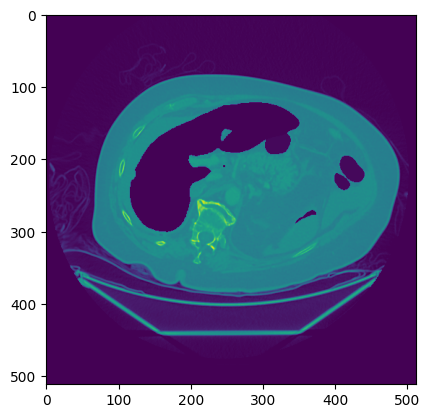

In [27]:
plt.imshow(np.where(mask[:,:,46]!=0,mask[:,:,46],im_dcm[:,:,0]))

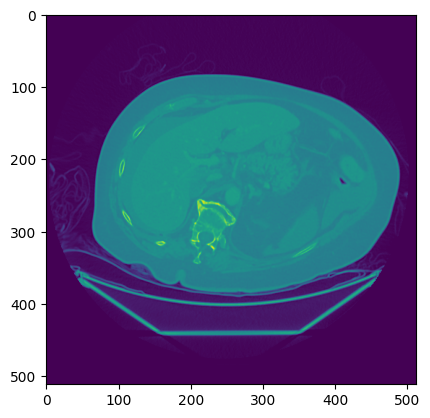

In [22]:
plt.imshow(im_dcm[:,:,0])

In [16]:
im_dcm, meta = load_dicom(f"{datadir}/train_images/1523/62556/18.dcm")

NameError: name 'datadir' is not defined

In [55]:
plt.imshow(im)
im = cv2.imread(f"../rsna-abdominal-2023/reduced_512_tickness_1/1523/62556/18.jpeg")
glob(f"../rsna-abdominal-2023/reduced_512_tickness_1/1523/62556/18.jpeg")

['../rsna-abdominal-2023/reduced_512_tickness_1/1523/62556/18.jpeg']

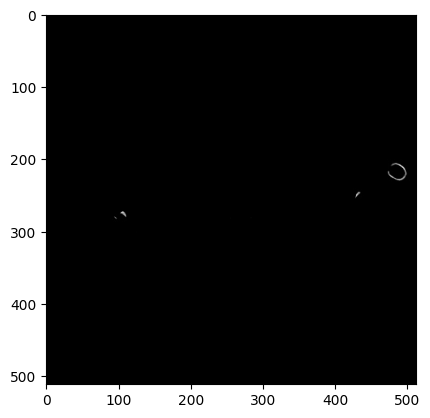

In [56]:
plt.imshow(im)

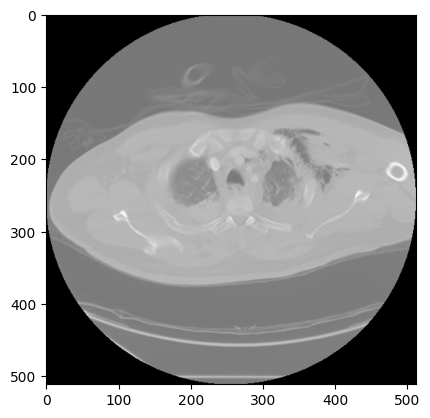

In [60]:
plt.imshow(im_dcm)

In [ ]:
mask = nib.load(ex_path)
mask = mask.get_fdata()  # convert to numpy array
mask = mask[:, ::-1, ::-1].transpose(1, 0, 2)

In [64]:
xx,count = np.unique(im_dcm==im,return_counts=True)

In [67]:
np.unique(im_dcm,return_counts=True)

(array([  0, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
        182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
        195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
        208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
        221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
        247, 248, 249, 250, 251, 252, 253, 254, 255], dtype=uint8),
 array([167316,     21,  14154,  75786,  15201,  14796,  42363,  34113,
         31113,  25962,  12615,   7194,   4392,   3660,   3108,   2457,
          1932,   2037,   1914,   2064,   2109,   2103,   

In [69]:
np.unique(im,return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  11,  12,  13,  14,
         15,  16,  17,  19,  20,  21,  22,  24,  25,  26,  28,  31,  33,
         37,  41,  43,  44,  52,  53,  55,  56,  57,  58,  59,  61,  62,
         63,  65,  66,  68,  69,  73,  74,  76,  77,  80,  81,  83,  84,
         85,  86,  88,  89,  90,  93,  94,  96,  97,  98,  99, 100, 101,
        102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 114, 117, 119,
        120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        134, 136, 137, 138, 139, 142, 144, 145, 146, 147, 148, 149, 150,
        151, 152, 154, 156, 157, 159, 160, 161, 163, 165, 166, 169, 170,
        171, 172, 173, 176, 178, 181, 182, 183, 186, 189, 194, 197, 201,
        204, 205, 207, 208, 209, 210, 215, 218, 221, 222, 223, 240, 254,
        255], dtype=uint8),
 array([784146,    819,    405,    204,     87,     45,     24,      3,
             6,      6,      3,      3,      6,      6,      6,      6,
             9,      3,  

In [58]:
im.shape

(512, 512, 3)

In [42]:
im

In [ ]:
im.shape[:2] != (512,512)

In [ ]:
im, _ = load_dicom("G:/RSNA2022RAWE/1.2.826.0.1.3680043.10633/100.dcm")

In [12]:

mask = nib.load("G:/RSNA2022RAWE/1.2.826.0.1.3680043.10633/1.2.826.0.1.3680043.10633.nii")
mask = mask.get_fdata()  # convert to numpy array
mask = mask[:, ::-1, ::-1].transpose(1, 0, 2)
mask.shape

(512, 512, 429)

In [ ]:
np.unique(im[:,:,1]==im[:,:,0])

array([ True])

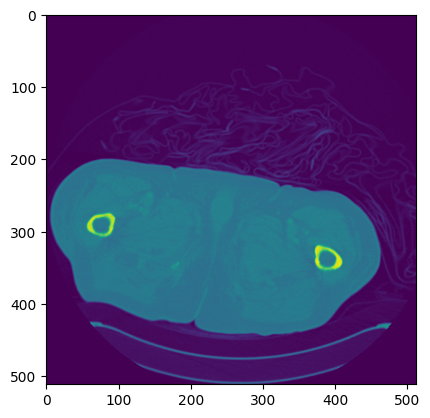

In [30]:
plt.imshow(im[:,:,1])

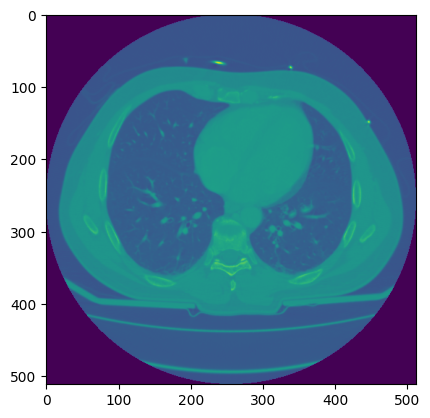

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(image_list[0])

In [ ]:

plt.imshow(image_list[1])

In [ ]:
image[0]

In [ ]:
image[1]

In [21]:
seg_25d_df

,id,StudyInstanceUID,slice_num,image_path,mask_path,fold,patient_id
0,35190_1,35190,1,.//seg_25d_image/35190_1.npy,.//seg_25d_mask/35190_1.npy,4,61547
1,35190_2,35190,2,.//seg_25d_image/35190_2.npy,.//seg_25d_mask/35190_2.npy,4,61547
2,35190_3,35190,3,.//seg_25d_image/35190_3.npy,.//seg_25d_mask/35190_3.npy,4,61547
3,35190_4,35190,4,.//seg_25d_image/35190_4.npy,.//seg_25d_mask/35190_4.npy,4,61547
4,35190_5,35190,5,.//seg_25d_image/35190_5.npy,.//seg_25d_mask/35190_5.npy,4,61547
...,...,...,...,...,...,...,...
38868,8413_318,8413,318,.//seg_25d_image/8413_318.npy,.//seg_25d_mask/8413_318.npy,1,14321
38869,8413_319,8413,319,.//seg_25d_image/8413_319.npy,.//seg_25d_mask/8413_319.npy,1,14321
38870,8413_320,8413,320,.//seg_25d_image/8413_320.npy,.//seg_25d_mask/8413_320.npy,1,14321
38871,8413_321,8413,321,.//seg_25d_image/8413_321.npy,.//seg_25d_mask/8413_321.npy,1,14321


In [22]:
seg_25d_df = pd.DataFrame(dataframe_list, columns=["id", "StudyInstanceUID", "slice_num", "image_path", "mask_path"])
seg_25d_df["fold"] = -1

gkf = GroupKFold(n_splits=5)
for idx, (train_index, test_index) in enumerate(gkf.split(X=seg_25d_df, groups=seg_25d_df['StudyInstanceUID'].values)):
    seg_25d_df.loc[test_index, 'fold'] = idx

In [14]:
seg_25d_df["patient_id"] = seg_25d_df["StudyInstanceUID"].apply(lambda x:s_id_p_id[x])

In [26]:
len(np.unique(seg_25d_df["StudyInstanceUID"].values))
#seg_25d_df

206

In [23]:
seg_25d_df[seg_25d_df["StudyInstanceUID"]=="12039"]

,id,StudyInstanceUID,slice_num,image_path,mask_path,fold
2886,12039_1,12039,1,.//seg_25d_image/12039_1.npy,.//seg_25d_mask/12039_1.npy,2
2887,12039_2,12039,2,.//seg_25d_image/12039_2.npy,.//seg_25d_mask/12039_2.npy,2
2888,12039_3,12039,3,.//seg_25d_image/12039_3.npy,.//seg_25d_mask/12039_3.npy,2
2889,12039_4,12039,4,.//seg_25d_image/12039_4.npy,.//seg_25d_mask/12039_4.npy,2
2890,12039_5,12039,5,.//seg_25d_image/12039_5.npy,.//seg_25d_mask/12039_5.npy,2
...,...,...,...,...,...,...
3244,12039_359,12039,359,.//seg_25d_image/12039_359.npy,.//seg_25d_mask/12039_359.npy,2
3245,12039_360,12039,360,.//seg_25d_image/12039_360.npy,.//seg_25d_mask/12039_360.npy,2
3246,12039_361,12039,361,.//seg_25d_image/12039_361.npy,.//seg_25d_mask/12039_361.npy,2
3247,12039_362,12039,362,.//seg_25d_image/12039_362.npy,.//seg_25d_mask/12039_362.npy,2


In [27]:
for i in range(5):
    study_num = len(np.unique(seg_25d_df[seg_25d_df["fold"] == i]["StudyInstanceUID"]))
    print(f"fold{i} num: {study_num}")

fold0 num: 42
fold1 num: 41
fold2 num: 41
fold3 num: 41
fold4 num: 41


In [28]:
seg_25d_df.to_csv(f"{datadir}/seg_25d.csv", index=False)

0 ---> background   
1 ---> C1   
2 ---> C2   
...     
8 ---> T1 - T12  